# Introduction

# Method

## 1. Construction of E.coli strains with different auxotrophic behaviors

1. [x] global medium context: anaerobic	 minimal	 conditions, glucose as sole carbon source. \
    glucose exchange >= -10 mmol/gDW/h, \
    minimal salt exchange >= -1000 mmol/gDW/h, \
    other exchange fluxes = 0.	\
    all reactions <= 1000 mmol/gDW/h, \
    ATP maintenance flux = 8.39 mmol/gDW/h.

2. [x] Auxotrophy for	one	or	two	amino	acids	is	imposed	by	setting	the	lower	and	upper	 bounds	 for	 reactions	 corresponding	 to	 the	relevant  genes	 (who's responsible	 for	 the	 synthesis	 of	 those	 amino	 acid)	 to	 zero.\
     01 and 10 represent phenotypes that are auxotrophic on one amino acid, with 00 representing phenotype auxotrophic to both amino acids.

3. [x] Amino	 acid	 leakiness	 was	 imposed	 in	 the	 model	 by	 setting	 the	 lower	 bounds	 of	 the	 corresponding	exchange	reactions	to	a	certain	percentage	of	the	maximum	value	of	 10 mmol/gDW/h.\
    *(it	should	be	noted	that	the	impact	of	leaking	an	amino	acid	at	a	particular	 leakiness	level	on	the	fitness	(growth)	of	that	phenotype	depends	not	only	on	the	cost	 of	synthesizing	that	amino	acid	but	also	on	its	transport	cost,	in	case	the	transport	of	 this	amino	acid	is	metabolically	or	energetically	costly	(all	these	costs	are	captured	 by	the	metabolic	network	model))*

In [2]:
## Import E.coli model ##

import cobra
from cobra.io import read_sbml_model

# model = read_sbml_model("../data/iJR904.xml")
model = read_sbml_model("../data/iJO1366.xml")
# model = read_sbml_model("../data/iJN1463.xml")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-18


In [1]:
## Define global medium ##
import pandas as pd
#1. Obtain M9 metabolites from carveme library
medium_lib = pd.read_csv("../data/media_db.tsv",sep="\t")

compound_M9 = medium_lib[medium_lib["medium"] == "M9"]

#2. Obtain M9 exchange reactions
medium_M9 = ["EX_"+str(compound)+"_e" for compound in compound_M9["compound"]]
print(medium_M9)

['EX_ca2_e', 'EX_cl_e', 'EX_cobalt2_e', 'EX_cu2_e', 'EX_fe2_e', 'EX_fe3_e', 'EX_glc__D_e', 'EX_h2o_e', 'EX_h_e', 'EX_k_e', 'EX_mg2_e', 'EX_mn2_e', 'EX_mobd_e', 'EX_na1_e', 'EX_nh4_e', 'EX_ni2_e', 'EX_o2_e', 'EX_pi_e', 'EX_so4_e', 'EX_zn2_e']


In [3]:
#3. Define medium based on M9 salt exchange reactions + glucose exchange
import numpy as np 

lb_global = -1000. #lower bound of minimal salt exchange
ub_global = 1000. #upper bound of all reactions
glucose_initial = 10.0
medium = dict(zip(medium_M9,np.repeat( - lb_global,len(medium_M9))))

medium["EX_o2_e"] = 2.0 #anaerobic condition
medium["EX_glc__D_e"] = glucose_initial

print(medium)
#assign medium to global model
model.medium = medium

#constrain maintenance ATP flux as 8.39
model.reactions.get_by_id("ATPM").lower_bound = 8.39
model.reactions.get_by_id("ATPM").upper_bound = 8.39
#default ATPM == 0.92

{'EX_ca2_e': 1000.0, 'EX_cl_e': 1000.0, 'EX_cobalt2_e': 1000.0, 'EX_cu2_e': 1000.0, 'EX_fe2_e': 1000.0, 'EX_fe3_e': 1000.0, 'EX_glc__D_e': 10.0, 'EX_h2o_e': 1000.0, 'EX_h_e': 1000.0, 'EX_k_e': 1000.0, 'EX_mg2_e': 1000.0, 'EX_mn2_e': 1000.0, 'EX_mobd_e': 1000.0, 'EX_na1_e': 1000.0, 'EX_nh4_e': 1000.0, 'EX_ni2_e': 1000.0, 'EX_o2_e': 2.0, 'EX_pi_e': 1000.0, 'EX_so4_e': 1000.0, 'EX_zn2_e': 1000.0}


In [4]:
## Knockout genes to construct different auxotrophic strains & 
## Constrain lower bound of exchange reactions to impose amino acid leakiness ##

from copy import deepcopy 
import pandas as pd

#1. get list of genes to be knocked out for each auxotrophic phenotype
amino_df = pd.read_csv("../data/amino_gene_knockout.tsv",sep="\t")

#select only one pair of amino acid as an example (construction based on more amino acid might require HPC)
amino_df = amino_df.iloc[[9,11]]
# amino_df = amino_df.iloc[[1,10]]
# amino_df = amino_df.iloc[[0,1]]
amino_df

,Amino acid,Gene knockouts,Auxotrophy
9,ile,b3770,EX_ile__L_e
11,lys,b2838,EX_lys__L_e


In [4]:
# amino_df.loc[1,"Auxotrophy"] = "EX_arg__L_e"

In [5]:
#2. knockout process

#initialization 
strains = {} #dictionary to store modified strains, keyed by pair of amino acid considered

for index1,row1 in amino_df.iterrows(): #loop through the first amino acid that strain may be auxotrophic to
    amino1 = row1[0]
    genes1 = row1[1].split(",")
    
    for index2,row2 in amino_df.loc[index1:].iterrows(): #loop through the second amino acid that strain may be auxotrophic to
        amino2 = row2[0]
        if amino2 == amino1: #exclude the same amino acid
            next
            
        else:
            genes2 = row2[1].split(",")

            #define phenotype 00 (auxotrophic to both) for this pair of amino acid
            key00 = str(amino1) + "_" + str(amino2) + "_" + "00"
            strains[key00] = deepcopy(model)
            
            key01 = str(amino1) + "_" + str(amino2) + "_" + "01"
            strains[key01] = deepcopy(model)
            #define phenotype 10 (auxotrophic to the first) for this pair of amino acid
            key02 = str(amino1) + "_" + str(amino2) + "_" + "02"
            strains[key02] = deepcopy(model)   
            #define phenotype 01 (auxotrophic to both) for this pair of amino acid
            key10 = str(amino1) + "_" + str(amino2) + "_" + "10"
            strains[key10] = deepcopy(model)
            #define phenotype 11 (leaky to both) for this pair of amino acid
            key20 = str(amino1) + "_" + str(amino2) + "_" + "20"
            strains[key20] = deepcopy(model)
            #define phenotype 22 (leaky to both) for this pair of amino acid
            key22 = str(amino1) + "_" + str(amino2) + "_" + "22"
            strains[key22] = deepcopy(model)
            
            
            for gene in genes1: 
                #knock out relevant genes for strains auxotrophic to the 1st amino acid
                strains_00 = getattr(strains[key00].genes, gene)
                strains_00.knock_out()
                
                strains_01 = getattr(strains[key01].genes, gene)
                strains_01.knock_out()

                strains_02 = getattr(strains[key02].genes, gene)
                strains_02.knock_out()

            print(f"for strain auxotrophic to {amino1} ({key01},{key02}), genes {genes1} are knocked out.")

            for gene in genes2: #knock out relevant genes for strains auxotrophic to the 2nd amino acid
                strains_00 = getattr(strains[key00].genes, gene)
                strains_00.knock_out()                

                strains_10 = getattr(strains[key10].genes, gene)
                strains_10.knock_out()

                strains_20 = getattr(strains[key20].genes, gene)
                strains_20.knock_out()
            
                
            print(f"for strain auxotrophic to {amino2} ({key20},{key10}), genes {genes2} are knocked out.")
            
print("\n Knockout finished, the modified strains are:",strains)

Read LP format model from file /tmp/tmpmx75xvah.lp
Reading time = 0.01 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
Read LP format model from file /tmp/tmpa03myxi_.lp
Reading time = 0.02 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
Read LP format model from file /tmp/tmpeycce14h.lp
Reading time = 0.01 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
Read LP format model from file /tmp/tmpqnw4wpmz.lp
Reading time = 0.02 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
Read LP format model from file /tmp/tmp8xfy8ai7.lp
Reading time = 0.02 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
Read LP format model from file /tmp/tmpcphbkxa7.lp
Reading time = 0.01 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
for strain auxotrophic to ile (ile_lys_01,ile_lys_02), genes ['b3770'] are knocked out.
for strain auxotrophic to lys (ile_lys_20,ile_lys_10), genes ['b2838'] are knocked out.

 Knockout finished, the modified strains are: {'ile_lys_00': <Model iJO1366 at 0x7f6eea57ce80>, '

### test if crossfeeding works

In [6]:
#2. Calculate payoff value for each phenotype in pairwise interaction
import warnings
warnings.filterwarnings("error")

payoff = [] #list to store FBA payoff value
N = 2 #only consider pairwise interaction
genotypes = ["01","10"]#list of genotypes for pairwise encounters
            
#create dataframe to store arbitrary leakiness level of selected amino acid pair
amino_list = amino_df["Amino acid"].to_list()
leakiness_data = [0.1,0.1] #arbitrary leakiness level
leakiness_df = pd.DataFrame(leakiness_data, columns=["leakiness"], index=amino_list)

for index1,row1 in amino_df.iterrows(): #loop through the 1st amino acid that strain may be auxotrophic to
    amino1 = row1[0]
    rxn1 = row1[2].split(",")#list of exchange reactions related to the leaked amino acid
    
    for index2,row2 in amino_df.loc[index1:].iterrows(): #loop through the 2nd amino acid that strain may be auxotrophic to
        amino2 = row2[0]
        if amino2 == amino1: #exclude the same amino acid
            next
            
        else:
            rxn2 = row2[2].split(",")
            
            for geno1 in genotypes:#1st genotype in encounter
                
                key_strains = str(amino1) + "_" + str(amino2) + "_" + geno1 #key reference for genotype in dictionary "strains"
                    
                for geno2 in genotypes:#2nd genotype that affects the physiology of the first genotype
                    
                    key_payoff = str(amino1) + "_" + str(amino2) + "_" + geno1 +"v"+geno2
                    
                    #parameters for export and uptake rate constraint
                    leakiness = [[int(geno1[0])*leakiness_df.loc[amino1],
                                int(geno1[1])*leakiness_df.loc[amino2]],#leakiness status for genotype1 to constrain minimum export rate
                                [int(geno2[0])*leakiness_df.loc[amino1],
                                int(geno2[1])*leakiness_df.loc[amino2]]]#... for genotype2 to constrain maximum uptake rate
                    #1st amino acid
                    N_A1 = int(geno1[0]) + int(geno2[0]) #number of leaky genotypes
                    net_export1 = min_export(N, N_A1, leakiness[0][0])#minimum flux of export
                    net_uptake1 = max_uptake(N, N_A1, leakiness[1][0])#maximum flux of uptake
                    #2nd amino acid
                    N_A2 = int(geno1[1]) + int(geno2[1]) 
                    net_export2 = min_export(N, N_A2, leakiness[0][1])#minimum flux of export
                    net_uptake2 = max_uptake(N, N_A2, leakiness[1][1])#maximum flux of uptake
              
                    #obtain FBA solution for encounter between genotype1 and genotype2
                    tmp_model = strains[key_strains]
                    with tmp_model:
                        #constraints relevant to 1st amino acid
                        #note that genotype1 can either uptake or export, cannot do both:

                        #check leakiness ability
                        if geno1[0] == "0":
                            #check uptake ability
                            if geno2[0] == "0":
                                next
                            else: #add uptake constraint
                                for rxn in rxn1: #loop through all exchange reactions relevant to amino acid 1
                                    tmp_model.reactions.get_by_id(rxn).lower_bound = - net_uptake1  
                                print(f"genotype {key_strains}'s {amino1} uptake in game {key_payoff} is constrained to be higher than {-net_uptake1}")
                        else: #add export constraint
                            for rxn in rxn1: #loop through all exchange reactions relevant to amino acid 1
                                tmp_model.reactions.get_by_id(rxn).lower_bound = net_export1
                            print(f"genotype {key_strains}'s {amino1} export in game {key_payoff} is constrained to be higher than {net_export1}")

                        #constraints relevant to 2nd amino acid
                        #check leakiness ability
                        if geno1[1] == "0":
                            #check uptake ability
                            if geno2[1] == "0":
                                next
                            else: #add uptake constraint
                                for rxn in rxn2: #loop through all exchange reactions relevant to amino acid 2
                                    tmp_model.reactions.get_by_id(rxn).lower_bound = - net_uptake2 
                        else: #add export constraint
                            for rxn in rxn2: #loop through all exchange reactions relevant to amino acid 2
                                tmp_model.reactions.get_by_id(rxn).lower_bound = net_export2
                        
                        #FBA optimization  
                        try:
                            payoff.append(tmp_model.optimize().objective_value)
                        except:
                            payoff.append(0.)


print("\n The uptake and export rates are constrained, the payoff values for row genotypes is: \n",payoff)




NameError: name 'min_export' is not defined

## (archived) Test whether mutants in addition to 00 have fitness advantage when encountering cross-feeder geno2

## Pregraphing - FBA growth under different combo of secretion levels

In [6]:
import numpy as np
#create dataframe to vary leakiness level of selected amino acid pair
start = 0.0
stop = 0.2625
interval = 0.0125
# start = 0.0
# stop = 5.05
# interval = 0.05
leakiness_range = np.arange(start,stop, interval, dtype=float)
leakiness_range = np.round(leakiness_range, decimals=4)
# leakiness_data = {"ile_leakiness": leakiness_range, "lys_leakiness": leakiness_range}
leakiness_data = {"ile_leakiness": leakiness_range, "lys_leakiness": leakiness_range}

leakiness_data
leakiness_df = pd.DataFrame(leakiness_data)

In [7]:
def get_additional_nutrient(concentration, Vmax, K):
    """Use external concentrations to bound the uptake flux of nutritious metabolites."""
    new_max_import = - Vmax * concentration /( K + concentration) #arbitrary value imitating shape of monod equation
    if abs(new_max_import) >= concentration:
        return - concentration #negative value, will be added to lower bound
    else:
        return new_max_import

In [65]:
growth_02 = one_FBA(strains[key02],"EX_lys__L_e","EX_ile__L_e",0.0,0.0001,1.)
print(growth_02)

0.00034419971844463034


In [8]:
def one_FBA(tmp_model,sec_rxn,up_rxn,sec,up,glucose=None):
    with tmp_model:
        #secretion level
        if glucose == None:
            glc = 10.
        else:
            glc = glucose
        tmp_model.reactions.get_by_id(sec_rxn).lower_bound = sec
        tmp_model.reactions.get_by_id(up_rxn).lower_bound = - up - 0.0001
        tmp_model.reactions.get_by_id(up_rxn).upper_bound = - up
        tmp_model.reactions.get_by_id("EX_glc__D_e").lower_bound = - glc
        try:
            growth = tmp_model.optimize().objective_value
            glc_flux = tmp_model.optimize().fluxes["EX_glc__D_e"]
        except:
            growth = -1.
            glc_flux = 0.
    return growth,glc_flux
        
        

In [56]:
import pandas as pd
import warnings
from tqdm import tqdm
os_experiment = []
warnings.filterwarnings("error")
# os_experiment = pd.DataFrame(columns = ["key_strain","sec","up","growth"])
# i = 0
mult = 1
overall_progress = tqdm(total=len(leakiness_df)**2, desc="Overall Progress")
for leak1 in leakiness_df["ile_leakiness"].tolist():
    for leak2 in leakiness_df["leu_leakiness"].tolist():
        key02 = "ile_leu_02"
        growth_02 = one_FBA(strains[key02],"EX_leu__L_e","EX_ile__L_e",leak2*mult,leak1)
        data_02 = (
        key02,
        leak2*mult,
        leak1,
        growth_02       
    ) 
        os_experiment.append(data_02)
        
        key20 = "ile_leu_20"
        growth_20 = one_FBA(strains[key20],"EX_ile__L_e","EX_leu__L_e",leak1*mult,leak2)
        data_20 = (
        key20,
        leak1*mult,
        leak2,
        growth_20       
    ) 
        os_experiment.append(data_20) 
        overall_progress.update(1)
overall_progress.close()
os_experiment_df = pd.DataFrame(os_experiment, columns = ["key_strain","sec","up","growth"])


Overall Progress: 100%|██████████████████████████████████████████████████████████████████████| 441/441 [00:41<00:00, 10.72it/s]


In [47]:
import pandas as pd
import warnings
from tqdm import tqdm
os_experiment = []
warnings.filterwarnings("error")
# os_experiment = pd.DataFrame(columns = ["key_strain","sec","up","growth"])
# i = 0
mult = 1
overall_progress = tqdm(total=len(leakiness_df)**2, desc="Overall Progress")
for leak1 in leakiness_df["ile_leakiness"].tolist():
    for leak2 in leakiness_df["lys_leakiness"].tolist():
        key02 = "ile_lys_02"
        growth_02,glc_02 = one_FBA(strains[key02],"EX_lys__L_e","EX_ile__L_e",leak2*mult,leak1,8.6)
        data_02 = (
        key02,
        leak2*mult,
        leak1,
        growth_02,
        glc_02
    ) 
        os_experiment.append(data_02)
        
        key20 = "ile_lys_20"
        growth_20,glc_20 = one_FBA(strains[key20],"EX_ile__L_e","EX_lys__L_e",leak1*mult,leak2,8.6)
        data_20 = (
        key20,
        leak1*mult,
        leak2,
        growth_20,
        glc_20
    ) 
        os_experiment.append(data_20) 
        overall_progress.update(1)
overall_progress.close()
os_experiment_df = pd.DataFrame(os_experiment, columns = ["key_strain","sec","up","growth","glc_flux"])




Overall Progress:  55%|██████████████████████████████████████▍                               | 242/441 [00:40<00:33,  5.99it/s]


Overall Progress:   0%|▏                                                                       | 1/441 [00:00<02:07,  3.45it/s]

Overall Progress:   0%|▎                                                                       | 2/441 [00:00<01:40,  4.36it/s]

Overall Progress:   1%|▍                                                                       | 3/441 [00:00<01:28,  4.97it/s]

Overall Progress:   1%|▋                                                                       | 4/441 [00:00<01:16,  5.73it/s]

Overall Progress:   1%|▊                                                                       | 5/441 [00:00<01:09,  6.23it/s]

Overall Progress:   1%|▉                                                                       | 6/441 [00:01<01:16,  5.70it/s]

Overall Progress:   2%|█▏                                                                     

In [43]:
set(os_experiment_df["glc_flux"])

{-10.0,
 -9.977537245582173,
 -9.960789598080275,
 -9.84141258369258,
 -9.814058247170566,
 -9.70939355078325,
 -9.597305429387497,
 -9.57111686117718,
 -8.268856924099774,
 -7.898913109878968,
 -7.844746443212201,
 -7.790579776545638,
 -7.736413109878969,
 -7.682246443212304,
 -7.6280797765456345,
 -7.573913109878969,
 -7.519746443212307,
 -7.465579776545635,
 -7.411413109878971,
 -7.357246443212301,
 -7.303079776545635,
 -7.2489131098788855,
 -7.194746443212235,
 -7.140579776545539,
 -7.086413109878903,
 -7.032246443212191,
 -6.97807977654554,
 -6.9239131098788835,
 -6.869746443212256,
 -6.815579776545568,
 -6.542867968551412,
 -5.116298955283654,
 -4.406174811980932,
 -4.381174811980932,
 -4.356174811980935,
 -4.331174811980933,
 -4.306174811980935,
 -4.281174811980932,
 -4.256174811980932,
 -4.231174811980935,
 -4.206174811980933,
 -4.181174811980935,
 -4.156174811980932,
 -4.131174811980931,
 -4.106174811980935,
 -4.081174811980933,
 -4.056174811980938,
 -4.031174811980932,
 -4.00

In [48]:
os_experiment_df.to_csv(f"../results/csv/one_shot/compare_sec_up_growth_{start}_{stop}_{interval}_sameSec_glc8.6.csv")

In [9]:
ref = pd.read_csv(f"../results/csv/one_shot/compare_sec_up_growth_{start}_{stop}_{interval}.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../results/csv/one_shot/compare_sec_up_growth_0.0_0.2625_0.0125.csv'

In [60]:
one_FBA(strains[key02],"EX_lys__L_e","EX_ile__L_e",0.05,9.0)

0.2851784445149478

In [63]:
max(os_experiment_df["growth"])

0.28878638777377114

In [49]:
ref.sort_values(by="up")

,Unnamed: 0,key_strain,sec,up,growth
0,0,ile_lys_02,0.00,0.00,0.000000
321,321,ile_lys_20,0.40,0.00,0.000000
28,28,ile_lys_02,0.70,0.00,0.000000
30,30,ile_lys_02,0.75,0.00,0.000000
721,721,ile_lys_20,0.90,0.00,0.000000
...,...,...,...,...,...
764,764,ile_lys_02,0.10,0.95,1.008198
766,766,ile_lys_02,0.15,0.95,1.001731
768,768,ile_lys_02,0.20,0.95,0.995264
519,519,ile_lys_20,0.60,0.95,0.943601


In [6]:
#Alternative knockout: based on strain 01 and 10 with at least 0.1 secretion of arg/leu, knockout genes one at a time. \
#see whether overproduction emerges
import warnings
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)
from tqdm import tqdm

warnings.filterwarnings("error")

leu_over = deepcopy(strains["arg_leu_01"])
# leu_over.reactions.get_by_id("EX_leu__L_e").lower_bound = 2.
leu_medium = leu_over.medium
leu_medium["EX_arg__L_e"] = 2.
# leu_medium["EX_orn_e"] = 2.
# leu_medium["EX_orn_e"] = 2.
leu_over.medium = leu_medium
with leu_over:
    print(leu_over.optimize())
arg_over = deepcopy(strains["arg_leu_10"])
# arg_over.reactions.get_by_id("EX_arg__L_e").lower_bound = 2.
# arg_over.reactions.get_by_id("EX_orn_e").lower_bound = 0.1
arg_medium = arg_over.medium
arg_medium["EX_leu__L_e"] = 2.
arg_over.medium = arg_medium
with arg_over:
    print(arg_over.optimize())
    
# none_over = deepcopy(strains["arg_leu_00"])
# # arg_over.reactions.get_by_id("EX_arg__L_e").lower_bound = 2.
# # arg_over.reactions.get_by_id("EX_orn_e").lower_bound = 0.1
# none_medium = none_over.medium
# none_medium["EX_leu__L_e"] = 0.5
# none_medium["EX_arg__L_e"] = 2.
# none_over.medium = none_medium
# with none_over:
#     print(none_over.optimize())
    
def find_overproduce(name, model_over):
    #vecterize dataframe for storage
    if name == "arg_over":   
        arg_fluxes = pd.DataFrame(columns=['growth','arg__L_flux', 'orn_flux','KO_gene'], index=range(1368))

        for i, gene in tqdm(enumerate(model_over.genes)):
            with model_over:
                gene = str(gene)
                try:
                    model_over.genes.get_by_id(gene).knock_out()
                    arg_fluxes.loc[i,"growth"] = model_over.optimize().objective_value
                    arg_fluxes.loc[i,["arg__L_flux","orn_flux"]] = model_over.optimize().fluxes[["EX_arg__L_e", "EX_orn_e"]].to_list()


                except:
                    arg_fluxes.loc[i,["growth","arg__L_flux","orn_flux"]] = [0, 0, 0]           
                # leu_fluxes.loc[i,"KO_gene"] = gene
                arg_fluxes.loc[i,"KO_gene"] = gene
                
        return arg_fluxes
    
    elif name == "leu_over":
        leu_fluxes = pd.DataFrame(columns=['growth','leu_flux', 'KO_gene'], index=range(1368))
        for i, gene in tqdm(enumerate(model_over.genes)):
            with model_over:
                gene = str(gene)
                try:
                    model_over.genes.get_by_id(gene).knock_out()
                    leu_fluxes.loc[i,"growth"] = model_over.optimize().objective_value         
                    leu_fluxes.loc[i,"leu_flux"] = model_over.optimize().fluxes["EX_leu__L_e"]
                    # arg_fluxes.loc[i,"arg__L_flux"] = model_over.optimize().fluxes["EX_arg__L_e"]
                    # arg_fluxes.loc[i,"orn_flux"] = model_over.optimize().fluxes["EX_orn_e"]


                except:
                    leu_fluxes.loc[i,["growth","leu_flux"]] = [0,0]
                    # arg_fluxes.loc[i,"arg__L_flux"] = 0            
                    # arg_fluxes.loc[i,"orn_flux"] = 0                             
                leu_fluxes.loc[i,"KO_gene"] = gene
                # arg_fluxes.loc[i,"KO_gene"] = gene
        return leu_fluxes

Read LP format model from file /tmp/tmpstae03a1.lp
Reading time = 0.02 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
<Solution 0.703 at 0x7fe8a85e6c50>
Read LP format model from file /tmp/tmpkcl2_thu.lp
Reading time = 0.01 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
<Solution 0.666 at 0x7fe8a55709a0>


In [15]:
leu_fluxes = find_overproduce("leu_over", leu_over)
arg_fluxes = find_overproduce("arg_over", arg_over)

1367it [01:23, 16.42it/s]
1367it [01:25, 15.94it/s]


In [16]:
good_orn = arg_fluxes[arg_fluxes["orn_flux"]>0.]
print(good_orn)

good_arg = arg_fluxes[arg_fluxes["arg__L_flux"]> 0.]
# good_arg = good_arg[good_arg["growth"] > 0.01]
print(good_arg)

good_leu = leu_fluxes[leu_fluxes["leu_flux"]> 0.]
# good_leu = good_leu[good_leu["growth"] > 0.01]
print(good_leu)

Empty DataFrame
Columns: [growth, arg__L_flux, orn_flux, KO_gene]
Index: []
Empty DataFrame
Columns: [growth, arg__L_flux, orn_flux, KO_gene]
Index: []
  growth  leu_flux KO_gene
9    0.0  0.384726   b3359


## 2. Computing the payoff values for amino acid-secreting E. coli strains

1. Net	 export	 and	 uptake	 level	 of	 each	 amino	 acid:\
    The	 net	 uptake	 rate	 of	 an	 amino	acid	A	for	a	phenotype	auxotroph	for	A	is	determined	as:\
    $$v_{net\_uptake} = \frac{N_A * p * 10}{N - 1}$$ \
    The net	 secretion	 (export)	 level	 of	 amino	 acid	 A	 by	 a	 phenotype	 that	is	leaky	for	A	is	determined	as:\
    $$v_{net\_export} = 10 * p - \frac{(N_A - 1) * p * 10}{N - 1}$$ \
    Where $N$	denotes	 the	 total	 number	 of	 phenotypes	 in	 a given encounter, $N_A$ denotes the	phenotypes that secret	 amino	 acid	 A in this encounter, $p$ represents the proportion of amino acid leaked to extracellular environment (i.e. feed the auxotrophic strains), and 10 is the constant representing the maximum export flux of all types of amino acid. 
    
2. Formulation of FBA problem: \
    Objective: (default) biomass optimization \
    Constraint: In addition to media constraint, ATPM constraint, and knocked-out reactions, the export and uptake flux of corresponding amino acid are constraint according to the above formula: \
    $v_{EX_A_e} \geq - v_{net\_uptake\_A}$ \ 
    for all strains that is auxotroph for amino acid A
    $v_{EX_A_e} \geq v_{net\_export\_A}$ \
    for all strains that is leaky for amino acid A

In [7]:
## Calculate net export and uptake level of each amino acid &
## Calculate payoff value from FBA optimization ##

#1. Initialization

#define formula
def max_uptake(N,N_A,leakiness): #formula to calculate maximum uptake rate for amino acid A
    """
    Formula to calculate maximum uptake rate for amino acid A. 
    N: (int) number of phenotypes participating the interaction;
    N_A: (int) number of phenotypes secreting amino acid A, 0 <= N_A <= N;
    leakiness: (float) proportion of amino acid A been secreted to extracellular environment
    """
    leakiness = float(leakiness)
    v_uptake = (N_A * leakiness *10)/(N - 1)
    return v_uptake

def min_export(N,N_A,leakiness): #formula to calculate maximum uptake rate for amino acid A
    """
    Formula to calculate minimum export rate for amino acid A. 
    N: (int) number of phenotypes participating the interaction;
    N_A: (int) number of phenotypes secreting amino acid A, 0 <= N_A <= N;
    leakiness: (float) proportion of amino acid A been secreted to extracellular environment
    """
    leakiness = float(leakiness)
    v_export = 10 * leakiness - ((N_A - 1) * leakiness * 10)/(N - 1)
    return v_export



## 3. Conduct invasion experiment via discrete replicator dynamics with updated metabolite concentration

In order to compare two-species mutualism community to two-species commensalism community in terms of their fitness benefit and see which one is evolutionarily stable, two types of invasion experiment are conducted.\
*Definition of evolutionarily stable community: A community is evolutionarily stable for which no mutants exist that can increase in frequency and alter the community composition (Kotil and Vetsigian 2018).*
1. Resident community is mutualistic: consists of strains 01 and 10; or strain 11 and 11. They are invaded by their own mutants with different strategies:
    - strains 01 & 10 are invaded by 00; 
<!--     - strain 11 and 11 are invaded by 10, 01, and then 00 at varies time steps (one mutant at a time) based on their mutation rate. -->
<!-- 2. Resident community is commensalistic: consists of strains 11 and 10; or 11 and 01; or 11 and 00 (10/01 and 00 rarely grow so not considered)
    - strains 11 and 10 are invaded by 01, 00 at varies time steps
    - strains 11 and 01 are invaded by 10, 00 at varies time steps
    - strains 11 and 00 are invaded by 01, 10 at varies time steps -->

In [8]:
## Update frequency and metabolite concentration for 1 time step (0.1h) ##

#1. Update abundance based on previous fitness value
#New abundance = old abundance + new frequency * old population size
#>> new frequency = (strain fitness - average fitness) * old frequency
#>> fitness of strain = sum(payoff when meeting strain i * frequency i) 
#>> payoff when meeting strain i >>
import warnings

def switch(pheno_loci):
    return max(int(pheno_loci) - 1, 0)

def get_FBA_result( param_ls, payoff_tmp, metabolite_ls, tmp_model):
    """FBA calculation based on one pair of encounter."""
    pheno1, pheno2, rxn1, rxn2, nutrient_df, net_uptake1, net_export1, net_uptake2, net_export2 = param_ls
        
    with tmp_model:
        #update glucose uptake rate based on external concentration
        new_glucose = get_additional_nutrient(nutrient_df.iloc[0][0], 10, Ks) #different Monod parameter compared to amino acid
        tmp_model.reactions.get_by_id("EX_glc__D_e").lower_bound = new_glucose
        ## constraints relevant to 1st amino acid ##
        #note that phenotype1 can either uptake or export, cannot do both:

        #check leakiness ability
        if pheno1[0] == "0" or pheno1[0] == "1":
            #check uptake ability
            if pheno2[0] == "0" or pheno2[0] == "1": #no strain secrete the 1st amino acid
                # next
                for rxn in rxn1: #loop through all exchange reactions relevant to amino acid 1
                    additional_nutrient = get_additional_nutrient(nutrient_df.loc[rxn][0], 10, Ks) #consider new additional nutrient in media
                    tmp_model.reactions.get_by_id(rxn).lower_bound = additional_nutrient 
                    #print(pheno1,"v",pheno2,rxn,additional_nutrient)
            else: #strain pheno2 scerete the 1st amino acid, tmp_model can therefore uptake it
                for rxn in rxn1: #loop through all exchange reactions relevant to amino acid 1
                    additional_nutrient = get_additional_nutrient(nutrient_df.loc[rxn][0], 10, Ks) #consider new additional nutrient in media
                    tmp_model.reactions.get_by_id(rxn).lower_bound = - net_uptake1  + additional_nutrient 
                    #print(pheno1,"v",pheno2,rxn,- net_uptake1  + additional_nutrient)
                # #print(f"phenotype {key_strains}'s {rxn} uptake in game {key_payoff} is less than {(- net_uptake1  + additional_nutrient) * biomass }")
        else: #add export constraint
            if pheno2[0] == "0" or pheno2[0] =="1":
                for rxn in rxn1: #loop through all exchange reactions relevant to amino acid 1
                    additional_nutrient = get_additional_nutrient(nutrient_df.loc[rxn][0], 10, Ks) 
                    tmp_model.reactions.get_by_id(rxn).lower_bound = net_export1 + additional_nutrient
                    #print(pheno1,"v",pheno2,rxn,net_export1 + additional_nutrient)
                # #print(f"phenotype {key_strains}'s {rxn} export in game {key_payoff} is higher than { net_export1 * biomass }")
            else:
                for rxn in rxn1:
                    tmp_model.reactions.get_by_id(rxn).lower_bound = 0.
                #print(pheno1,"v",pheno2,"ile",0.)
 
        ## constraints relevant to 2nd amino acid ##
        #check leakiness ability
        if pheno1[1] == "0"or pheno1[1] =="1":
            #check uptake ability
            if pheno2[1] == "0"or pheno2[1] =="1":
                # next
                for rxn in rxn2: #loop through all exchange reactions relevant to amino acid 2
                    additional_nutrient = get_additional_nutrient(nutrient_df.loc[rxn][0], 10, Ks)                            
                    tmp_model.reactions.get_by_id(rxn).lower_bound = additional_nutrient
                    #print(pheno1,"v",pheno2,rxn,additional_nutrient)
            else: #add uptake constraint                
                for rxn in rxn2: #loop through all exchange reactions relevant to amino acid 2
                    additional_nutrient = get_additional_nutrient(nutrient_df.loc[rxn][0], 10, Ks)                            
                    tmp_model.reactions.get_by_id(rxn).lower_bound = - net_uptake2  + additional_nutrient
                    #print(pheno1,"v",pheno2,rxn,- net_uptake2  + additional_nutrient)
                # #print(f"phenotype {key_strains}'s {rxn} uptake in game {key_payoff} is less than {(- net_uptake2  + additional_nutrient) * biomass }")

        else: #add export constraint
            if pheno2[1] == "0"or pheno2[1] == "1":
                for rxn in rxn2: #loop through all exchange reactions relevant to amino acid 2
                    additional_nutrient = get_additional_nutrient(nutrient_df.loc[rxn][0], 10, Ks)                     
                    tmp_model.reactions.get_by_id(rxn).lower_bound = net_export2 + additional_nutrient
                    #print(pheno1,"v",pheno2,rxn,net_export2 + additional_nutrient)
            else:
                for rxn in rxn2: 
                    tmp_model.reactions.get_by_id(rxn).lower_bound = 0.
                #print(pheno1,"v",pheno2,"EX_lys__L_e",0.)

                    # #print(f"phenotype {key_strains}'s {rxn} export in game {key_payoff} is higher than { net_export2 * biomass }")
        #FBA optimization  
        try:
            #append pheno1's fitness value for each encounter
            payoff_tmp.append(tmp_model.optimize().objective_value)
            #append pheno1's metabolite exchange for each encounter
            metabolite_ls.append(np.array(tmp_model.optimize().fluxes[rxn_ls]))

        except:
            payoff_tmp.append(0.)
            metabolite_ls.append(np.repeat(0.,len(rxn_ls)))
                

    return payoff_tmp, metabolite_ls

def get_pairwise_payoff(generation_df, nutrient_df, amino_df,leakiness_df,strains,phenotypes):
    
    """
    Calculate payoff matrix in pairwise interactions.
    
    INPUTS:
    --------

    amino_df:
    a dataframe with two rows, containing name of amino acid (1st col), corresponding synthesis genes(2nd col),
    exchange reactions that leak/uptake the corresponding amino acid (3rd col).
    
    leakiness_df:
    a dataframe with leakiness level of the 1st and 2nd amino acids.
    
    strains:
    a dictionary storing the gene-knocked-out models. key: str(amino1) + "_" + str(amino2) + "_" + phenotype
    values datatype: COBRA model
    
    phenotypes:
    a list of all phenotypes involved in interactions such as ["00","01","10","11"].
    
    """
    warnings.filterwarnings("error")

    payoff = [] #list to store FBA payoff value representing theoretical fitness score
    growth = [] #temporal list to store actual growth value
    metabolite_ls = [] #list to store flux of selected amino acid
    N = 2 #only consider pairwise interaction


    amino1 = amino_df.iloc[0,0]#1st amino acid that phenotypes may be auxotrophic to
    rxn1 = amino_df.iloc[0,2].split(",")#list of exchange reactions related to the leaked amino acid

    amino2 = amino_df.iloc[1,0]
    rxn2 = amino_df.iloc[1,2].split(",")

    rxn_ls = ["EX_glc__D_e"] + rxn1 + rxn2 #exchange reactions to record metabolite exchange
    

    for pheno1 in phenotypes:#1st phenotype in encounter
        
        strain_biomass = generation_df["abundance"].loc[pheno1]

        key_strains = f"{amino1}_{amino2}_{pheno1}" #key reference for phenotype in dictionary "strains"

        for pheno2 in phenotypes:#2nd phenotype that affects the physiology of the first phenotype

            # key_payoff = str(amino1) + "_" + str(amino2) + "_" + pheno1 +"v"+pheno2

            #### setting parameters for export and uptake rate constraint ####
            #parameters for export and uptake rate constraint
            leakiness = [[switch(pheno1[0])*leakiness_df.loc[amino1],
                        switch(pheno1[1])*leakiness_df.loc[amino2]],#leakiness status for phenotype1 to constrain minimum export rate
                        [switch(pheno2[0])*leakiness_df.loc[amino1],
                        switch(pheno2[1])*leakiness_df.loc[amino2]]]#... for phenotype2 to constrain maximum uptake rate
            # #print(pheno1, pheno2, leakiness)
            #1st amino acid
            N_A1 = switch(pheno1[0]) + switch(pheno2[0]) #number of leaky phenotypes
            net_export1 = min_export(N, N_A1, leakiness[0][0])#minimum flux of export
            net_uptake1 = max_uptake(N, N_A1, leakiness[1][0])#maximum flux of uptake
            #2nd amino acid
            N_A2 = switch(pheno1[1]) + switch(pheno2[1]) 
            net_export2 = min_export(N, N_A2, leakiness[0][1])#minimum flux of export
            net_uptake2 = max_uptake(N, N_A2, leakiness[1][1])#maximum flux of uptake


            #### obtain FBA solution for encounter between phenotype1 and phenotype2 ####
            tmp_model = strains[key_strains]
            param_ls = [ pheno1, pheno2, rxn1, rxn2, nutrient_df, net_uptake1, net_export1, net_uptake2, net_export2 ]
            payoff, metabolite_ls = get_FBA_result(param_ls, payoff, metabolite_ls, tmp_model)
    
    #summarize payoff values    
    payoff_values = np.array(payoff)
    payoff_matrix = payoff_values.reshape(-1, len(phenotypes)) #here's the payoff matrix we will be using
    payoff_df = pd.DataFrame(payoff_matrix, columns = phenotypes, index = phenotypes) #a reference for players in this payoff matrix

    # print(payoff_df)

    return payoff_df, metabolite_ls, payoff_values

#fitness of strain = sum(payoff when meeting strain i * frequency i) >>
def get_strain_fitness_ls(phenotypes, payoff_df,freq_ls):
    """
    Calculate fitness of selected strain.
    """
    fitness_ls = []
    for strain in phenotypes:
        # fitness_ls.append(sum(np.exp(np.log(payoff_df.loc[strain].to_numpy()/div_met + 0.000001)) * freq_ls))
        fitness_ls.append(sum(payoff_df.loc[strain].to_numpy()* freq_ls))
        # print(strain,"\n fitness",payoff_df.loc[strain].to_numpy()/60, sum(np.exp(np.log(payoff_df.loc[strain]/60 + 0.000001)) * freq_ls))
        # print("freq", freq_ls)
    return fitness_ls

def get_avg_fitness_ls(strain, fitness_ls, phenotypes, payoff_df,freq_ls):
    """
    Calculate average fitness of selected strain.    
    """
    #multiply the fitness and frequency of each other strain
    strain_idx = phenotypes.index(strain)
    other_ids = list(range(len(phenotypes)))
    other_ids.remove(strain_idx)
    avg_fitness_ls = [fitness_ls[i]*freq_ls[i] for i in other_ids]
    # print(avg_fitness_ls)
    #print("avg_fit", strain,avg_fitness_ls)
    return avg_fitness_ls
    
#new frequency = (strain fitness - average fitness) * old frequency >>
def get_freq_prob(strain, fitness_ls, phenotypes, payoff_df, freq_ls):
    """
    Calculate new frequency of selected strain based on discrete replicator dynamics.
    
    INPUTS:
    --------
    strain:
    a string (e.g. "00")

    phenotypes:
    a list of all phenotypes involved in interactions such as ["00","01","10","11"].  
    
    payoff_df:
    a dataframe containing payoff matrix, indexed by participating phenotypes in this game.
    
    freq_ls:
    a list of frequencies of participating phenotypes.
    SHOULD BE IN THE SAME ORDER AS [phenotypes].
    
    """
    avg_fitness_ls = get_avg_fitness_ls(strain, fitness_ls, phenotypes, payoff_df,freq_ls)    
    avg_fitness = sum(avg_fitness_ls)
    # print("avg_fit",avg_fitness)
    strain_idx = phenotypes.index(strain)
    if avg_fitness == 0.:
        if fitness_ls[strain_idx] == 0.:
            freq_prob = 0.
        else:
            freq_prob = 1.
    else:
        freq_prob = fitness_ls[strain_idx] * freq_ls[strain_idx] / avg_fitness
    # print("freq_prob",strain, freq_prob)
    return freq_prob

#>>| New abundance = old abundance + new frequency * old population size
def get_abundance(strain, phenotypes, payoff_df, freq_ls, abundance_ls):
    pop = sum(abundance_ls)
    strain_idx = phenotypes.index(strain)
    death_ls = payoff_df.loc[strain].to_numpy()
    death_ids = np.where(death_ls == 0.)
    # print(death_ids)
    if len(death_ids) == 0:       
        new_abundance = abundance_ls[strain_idx] + (freq_ls[strain_idx] * pop/division)#per min growth
    else:
        new_abundance = abundance_ls[strain_idx] + ((freq_ls[strain_idx] * pop) - sum( death_rate * freq_ls[strain_idx] *freq_ls[death_ids]*pop ))/division 
    # new_abundance = pop_ls[strain_idx]
        # print(strain, "\ndeath",sum( death_rate * freq_ls[strain_idx] *freq_ls[death_ids]*sum(abundance_ls)))
    return new_abundance

####-----------------------------------------------------------------------------####

#2. Update metabolite concentration based on strain abundance
def get_nutrient_flux(metabolite_ls, phenotypes, freq_ls, population):
    """Sum up nutritious metabolite exchange flux by strains based on frequencies of their opponents."""
    #initiate variables for storage and iteration
    zero_arr = np.repeat(0., len(metabolite_ls[0]))
    total_nutrient_flux = zero_arr
    strain_count = len(phenotypes)
    
    for i in range(0,len(metabolite_ls)):
        #first we need to know which pair of encounter the selected metabolic exchange belongs to         
        pheno1_idx,pheno2_idx = divmod(i, strain_count)
        # print(i,pheno1_idx,pheno2_idx)

        if np.all(metabolite_ls[i] == 0): #set pairs infeasible if contributor strain is infeasible (?what if it's consumer strain infeasible)
            reverse_i = pheno2_idx * strain_count + pheno1_idx
            # print(population,pheno1_idx,pheno2_idx,"Find infeasible pair, now fixing the values...")
            if reverse_i > i:
                 #if the wrong data is already added, we will do a reversed calculation to fix it
                strain_nutrient_flux = - metabolite_ls[reverse_i] * freq_ls[pheno1_idx]* freq_ls[pheno2_idx] *population/ div_met
                total_nutrient_flux = np.add(total_nutrient_flux, strain_nutrient_flux)  
        else:
            # strain_nutrient_flux = metabolite_ls[i] * freq_ls[pheno1_idx] * freq_ls[pheno2_idx] / 60#originally should be *population and /10e6, they cancel one another here
            strain_nutrient_flux = metabolite_ls[i] * freq_ls[pheno1_idx]* freq_ls[pheno2_idx]*population / div_met
            # print(i,metabolite_ls[i],strain_nutrient_flux)
            # print(metabolite_ls[i],freq_ls[pheno1_idx],freq_ls[pheno2_idx],population)
            total_nutrient_flux = np.add(total_nutrient_flux, strain_nutrient_flux)                        
    # print("phenotypes",phenotypes, "\n freq_ls",freq_ls, "\n total_nutrient_flux",total_nutrient_flux)
    return total_nutrient_flux
        

#3. Update constraints
def get_reaction_list(amino_df): 
    """Obtain exchange reactions for nutritious metabolites."""
    amino1 = amino_df.iloc[0,0]#1st amino acid that phenotypes may be auxotrophic to
    rxn1 = amino_df.iloc[0,2].split(",")#list of exchange reactions related to the leaked amino acid

    amino2 = amino_df.iloc[1,0]
    rxn2 = amino_df.iloc[1,2].split(",")

    rxn_ls = ["EX_glc__D_e"] + rxn1 + rxn2 #exchange reactions to record metabolite exchange
    
    return rxn_ls

def get_additional_nutrient(concentration, Vmax, K):
    """Use external concentrations to bound the uptake flux of nutritious metabolites."""
    new_max_import = - Vmax * concentration /( K + concentration) #arbitrary value imitating shape of monod equation
    if abs(new_max_import) >= concentration:
        return - concentration #negative value, will be added to lower bound
    else:
        return new_max_import
        
#  Vgmax * (Gluc / (Kg + Gluc)):https://bionumbers.hms.harvard.edu/bionumber.aspx?id=111049
# 0.97 * glucose / (0.0222 + glucose)

#4. update payoff

#NEXT: 
#combine concentration addition with payoff calculation, esp. join loop of rxn with selection of nutrient fluxes
    

### test generational update

In [9]:
def update_generation(generation_df,nutrient_df,amino_df,leakiness_df,strains):
    #unbox dataframe
    phenotypes = list(generation_df.index)
    freq_ls = generation_df["frequency"].to_numpy()
    abundance_ls = generation_df["abundance"].to_numpy()
    n = 10e6
    #check previous abundance
    # print(generation_df, nutrient_df)
    #calculate payoff matrix
    payoff_df, metabolite_ls,payoff = get_pairwise_payoff(generation_df, nutrient_df, amino_df,leakiness_df,strains,phenotypes)
    # print(payoff_df)

    #update abundance based on discrete replicator dynamics
    fitness_ls = get_strain_fitness_ls(phenotypes, payoff_df,freq_ls)
    # print(fitness_ls)
    freq_prob = np.array([get_freq_prob(strain, fitness_ls, phenotypes, payoff_df, freq_ls) for strain in phenotypes])
    # print(freq_prob)
    if np.sum(freq_prob) == 0.:
        # print("all dead!")
        sample = np.repeat(0.,len(phenotypes))
    else:
        freq_dist = freq_prob / np.sum(freq_prob)
        sample = np.random.multinomial(n, freq_dist)  
    # print(sample)
    # sample = - sample        
    freq_new =np.round(sample /n,8)
    # print(freq_new)
    # pop_ls = np.random.multinomial(n, freq_dist)
    # print("new frequency",pop_ls)
    abundance_ls = np.array([ get_abundance(strain, phenotypes, payoff_df, freq_new, abundance_ls) for strain in phenotypes])
    # print(abundance_ls)
    population = np.sum(abundance_ls)

    #update nutrient concentration
    new_nutrient_flux = get_nutrient_flux(metabolite_ls, phenotypes, freq_ls,population)
    # print("nutrient_flux",new_nutrient_flux)
    
    temp_concentration = nutrient_df["concentration"].to_numpy() + new_nutrient_flux
    # temp_concentration = np.array(temp_concentration)
    # neg_ids = np.where(temp_concentration < 0)
    temp_concentration[temp_concentration < 0] = 0.0 #make sure no negative concentration
    nutrient_df["concentration"] = temp_concentration

    
    updated_values = {
        "abundance": abundance_ls,
        "frequency": abundance_ls / population
    }
    generation_df = generation_df.assign(**updated_values)
    # print(generation_df, nutrient_df)

    return generation_df, nutrient_df,payoff


### crossfeeding experiment

In [129]:
#cross-feeding
def perform_crossfeeding(iteration, amino_df, leakiness_df, strains, freq_ls, abundance_ls, rxn_ls, phenotypes):
   #initiation
    generation_df = pd.DataFrame(zip(freq_ls,abundance_ls),index = phenotypes, columns = ["frequency", "abundance"])
    init_concentration = np.concatenate(([100.],np.repeat(0., len(rxn_ls)-1)),axis=0)
    init_nutrient_flux = np.repeat(0.,len(rxn_ls))
    nutrient_df = pd.DataFrame(init_concentration, index = rxn_ls, columns = ["concentration"])
    payoff = np.repeat(0., 4)
    experiment = []
    data = (
        generation_df["frequency"].tolist(),
        generation_df["abundance"].tolist(),
        nutrient_df["concentration"].tolist(),
        payoff.tolist()
    )    
    experiment.append(data)
    for step in range(1, iteration, 1):
        generation_df, nutrient_df,payoff = update_generation(generation_df, nutrient_df, amino_df, leakiness_df, strains)
        data = (
            generation_df["frequency"].tolist(),
            generation_df["abundance"].tolist(),
            nutrient_df["concentration"].tolist(),
            payoff.tolist()
        )
        # print(payoff_df)
        experiment.append(data)

    experiment = pd.DataFrame(experiment, columns=["frequency", "abundance", "concentration","payoff"])
    return experiment


In [346]:
#Loop through 60 min and store frequency, abundance, metabolite concentration, and time data
from tqdm import tqdm
#intialize constant starting values
phenotypes =  ["02","20"]
mu = 0.0#mutation rate
n = 10e6 #integer for multinomial sampling
freq_ls = np.array([(1-mu)*0.5,(1-mu)*0.5])
abundance_ls = freq_ls
Ks = 0.1
division = 1
div_met = 60
rxn_ls = get_reaction_list(amino_df)
iteration = 60
amino_list = amino_df["Amino acid"].to_list()

#create dataframe to vary leakiness level of selected amino acid pair
leakiness_range = np.arange(0.1, 0.4, 0.1, dtype=float)
leakiness_range = np.round(leakiness_range, decimals=2)
leakiness_data = {"ile_leakiness": leakiness_range, "lys_leakiness": leakiness_range}
leakiness_data
leakiness_df = pd.DataFrame(leakiness_data)

In [239]:
leakiness_df.to_csv("../results/csv/leakiness_df_4.csv")

In [266]:
#pre testing
# for replicate in range(1,11,1):
replicate = 0
leakiness_data = [0.3,0.3] #arbitrary leakiness level
# print(leakiness_data)
tmp_leakiness = pd.DataFrame(leakiness_data, columns=["leakiness"], index=amino_list)

cf_experiment = perform_crossfeeding(iteration, amino_df,tmp_leakiness,strains,freq_ls, abundance_ls, rxn_ls,phenotypes)
# cf_experiment
# tmp_experiment.to_csv(f"../results/csv/invasion_experiments/invasion-20v02-{iteration}min-ile{leak1}_lys{leak2}_{replicate}.csv")

In [131]:
cf_experiment

,frequency,abundance,concentration,payoff
0,"[0.5, 0.5]","[0.5, 0.5]","[100.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]"
1,"[0.5, 0.5]","[0.748955999279, 0.748955999279]","[99.8333499983335, 0.008120872419680842, 0.008...","[0.0, 0.1755095679832239, 0.18727137864671173,..."
2,"[0.49119199999999996, 0.508808]","[1.4715247807914023, 1.5242992163245979]","[99.6667000244828, 0.01617352378584215, 0.0160...","[0.027952020003789095, 0.17596152976785248, 0...."
3,"[0.48883400000000005, 0.511166]","[2.928921255612406, 3.0627267386195944]","[99.5000500785409, 0.024158381725523682, 0.023...","[0.055669223333444, 0.1764096882616847, 0.1880..."
4,"[0.489633, 0.510367]","[5.867417164719594, 6.115878823744406]","[99.33340016060127, 0.03207675370982332, 0.031...","[0.08315308188003154, 0.17685380306464452, 0.1..."
5,"[0.49285700000000005, 0.5071429999999999]","[11.812102621972805, 12.154489354955196]","[99.16675027075787, 0.039930211858159384, 0.03...","[0.11040809595538938, 0.177293977412235, 0.188..."
6,"[0.49928950000000005, 0.5007105]","[23.93253544972879, 24.000648504127213]","[99.0001004091051, 0.04771874094024373, 0.0472...","[0.137439676790129, 0.17773042055346355, 0.189..."
7,"[0.51029825, 0.48970174999999994]","[48.9204397771616, 46.9459281305504]","[98.83345057573787, 0.05543929337656083, 0.054...","[0.16424777196164148, 0.17816333688663874, 0.1..."
8,"[0.528642625, 0.4713573749999999]","[101.35809675989726, 90.37463905552673]","[98.66680077075154, 0.06308148027327161, 0.054...","[0.19082189170981498, 0.17859293441396168, 0.1..."
9,"[0.5737203125, 0.42627968749999995]","[220.00193021701, 163.463541413838]","[98.50015099424196, 0.07061623622303449, 0.061...","[0.2171262774913059, 0.17855487488144897, 0.19..."


In [134]:
#loop through varies leakiness pair
# for replicate in range(1,11,1):
replicate = 0
for leak1 in leakiness_df["ile_leakiness"].tolist():
    for leak2 in leakiness_df["lys_leakiness"].tolist():
        leakiness_data = [leak1,leak2] #arbitrary leakiness level
        print(leakiness_data)
        tmp_leakiness = pd.DataFrame(leakiness_data, columns=["leakiness"], index=amino_list)
        try:
            tmp_experiment = perform_crossfeeding(iteration, amino_df,tmp_leakiness,strains,freq_ls, abundance_ls, rxn_ls,phenotypes)
        except: 
            tmp_experiment = pd.DataFrame(columns = ["frequency","abundance","concentration"])
        tmp_experiment.to_csv(f"../results/csv/invasion_experiments/crossfeeding-20v02-{iteration}min-ile{leak1}_lys{leak2}_{division}_{div_met}.csv")

[0.1, 0.1]
[0.1, 0.2]
[0.1, 0.3]
[0.1, 0.4]
[0.2, 0.1]
[0.2, 0.2]
[0.2, 0.3]
[0.2, 0.4]
[0.3, 0.1]
[0.3, 0.2]
[0.3, 0.3]
[0.3, 0.4]
[0.4, 0.1]
[0.4, 0.2]
[0.4, 0.3]
[0.4, 0.4]


### Invasion experiment

In [10]:
#invasion
def perform_invasion(iteration, amino_df, leakiness_df, strains, freq_ls, abundance_ls, rxn_ls, phenotypes):
   #initiation
    generation_df = pd.DataFrame(zip(freq_ls,abundance_ls),index = phenotypes, columns = ["frequency", "abundance"])
    init_concentration = np.concatenate(([10.0],np.repeat(0., len(rxn_ls)-1)),axis=0)
    init_nutrient_flux = np.repeat(0.,len(rxn_ls))
    nutrient_df = pd.DataFrame(init_concentration, index = rxn_ls, columns = ["concentration"])
    init_payoff = np.repeat(0.,len(phenotypes)**2)
    
    experiment = []
    data = (
        generation_df["frequency"].tolist(),
        generation_df["abundance"].tolist(),
        nutrient_df["concentration"].tolist(),
        init_payoff.tolist()
    )    
    experiment.append(data)
    # print(experiment)
    for step in range(1, iteration, 1):
        # print(step)
        generation_df, nutrient_df,payoff = update_generation(generation_df, nutrient_df, amino_df, leakiness_df, strains)
        data = (
                generation_df["frequency"].tolist(),
                generation_df["abundance"].tolist(),
                nutrient_df["concentration"].tolist(),
                payoff.tolist()
            )

        experiment.append(data)

    experiment = pd.DataFrame(experiment, columns=["frequency", "abundance", "concentration","payoff"])
    # print(amino_df,rxn_ls)
    return experiment


In [30]:
#Loop through 60 min and store frequency, abundance, metabolite concentration, and time data
from tqdm import tqdm
#intialize constant starting values
phenotypes =  ["02","20","01","10"]
mu = 0.05 #mutation rate
init_pop = 0.000001
n = 10e6 #integer for multinomial sampling
# freq_ls = np.array([(1-mu)*0.5,mu, mu])
freq_ls = np.array([(1-mu)*0.5,(1-mu)*0.5,mu, mu])
abundance_ls = freq_ls *init_pop
Ks = 0.01
death_rate = 1
division = 1
div_met = 3
rxn_ls = get_reaction_list(amino_df)
iteration = 36
amino_list = amino_df["Amino acid"].to_list()

#create dataframe to vary leakiness level of selected amino acid pair
leakiness_range = np.arange(0.1, 0.4, 0.1, dtype=float)
leakiness_range = np.round(leakiness_range, decimals=2)
leakiness_data = {"arg_leakiness": leakiness_range, "leu_leakiness": leakiness_range}
leakiness_data
leakiness_df = pd.DataFrame(leakiness_data)

In [28]:
#pre testing for invasion
leakiness_data = [0.1, 0.3]
leakiness_df = pd.DataFrame(leakiness_data, columns=["leakiness"], index=amino_list)
# i = 1
tmp_experiment = perform_invasion(iteration, amino_df,leakiness_df,strains,freq_ls, abundance_ls, rxn_ls,phenotypes)

In [31]:
#loop through varies leakiness pair
# for replicate in range(1,11,1):
replicate = 0
for leak1 in leakiness_df["arg_leakiness"].tolist():
    for leak2 in leakiness_df["leu_leakiness"].tolist():
        leakiness_data = [leak1,leak2] #arbitrary leakiness level
        print(leakiness_data)
        tmp_leakiness = pd.DataFrame(leakiness_data, columns=["leakiness"], index=amino_list)
        try:
            tmp_experiment = perform_invasion(iteration, amino_df,tmp_leakiness,strains,freq_ls, abundance_ls, rxn_ls,phenotypes)
        except: 
            tmp_experiment = pd.DataFrame(columns = ["frequency","abundance","concentration"])
        tmp_experiment.to_csv(f"../results/csv/invasion_experiments/invasion-20v02_10_01-{iteration}min-arg{leak1}_leu{leak2}_{division}_{div_met}.csv")

[0.1, 0.1]
[0.1, 0.2]
[0.1, 0.3]
[0.1, 0.4]
[0.2, 0.1]
[0.2, 0.2]
[0.2, 0.3]
[0.2, 0.4]
[0.3, 0.1]
[0.3, 0.2]
[0.3, 0.3]
[0.3, 0.4]
[0.4, 0.1]
[0.4, 0.2]
[0.4, 0.3]
[0.4, 0.4]


In [249]:
#loop through varies entry point
# leakiness_data = [0.1, 0.1]
# tmp_leakiness = pd.DataFrame(leakiness_data, columns=["leakiness"], index=amino_list)
for leak in tqdm([0.1,0.2,0.3,0.4]):
    leakiness_data = [leak, leak]
    tmp_leakiness = pd.DataFrame(leakiness_data, columns=["leakiness"], index=amino_list)
    # try:
    tmp_experiment = perform_invasion(1, iteration, amino_df,tmp_leakiness,strains,freq_ls, abundance_ls, rxn_ls,phenotypes)
    # except: 
        # tmp_experiment = pd.DataFrame(columns = ["frequency","abundance","concentration"])
    tmp_experiment.to_csv(f"../results/csv/invasion_experiments/invasion-10_01v00-{iteration}min-ile{leak}_lys{leak}.csv")

100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:58<00:00, 74.52s/it]


In [90]:
tmp_experiment.iloc[0]["frequency"]

[0.6739303829218896, 0.3260696170781105, 0.0]

In [107]:
import sys
np.set_printoptions(threshold=sys.maxsize)
test_exp = pd.read_csv("../results/csv/invasion_experiments/invasion-10_01v00-60min-3entry.csv")
j = 8
print(test_exp.iloc[j]["frequency"])
print(test_exp.iloc[j]["abundance"])
print(test_exp.iloc[j]["concentration"])

[0.5118776106218342, 0.44408081781233866, 0.044041571565827116]
[0.5827841281131572, 0.505595960538584, 0.05014231596209797]
[28.566778385208202, 0.09737772619296664, 0.0010968016819135268, 0.03028319147017926]


## Temporal plotting

In [267]:
tmp_experiment = cf_experiment

In [15]:
#for tmp plotting
def unlist(input_list):
    output_list = []
    for item in input_list:
        if isinstance(item, list):
            output_list.extend(unlist(item))
        else:
            output_list.append(item)
    return output_list

# concentration_data = unlist(tmp_experiment["concentration"])

In [16]:
# determine total time steps
# iteration = exp_data.shape[0]
# plot1 - frequency
# phenotypes = ["01","10","02","20"]
phenotypes = ["02","20","01","10"]
# phenotypes = ["02","20"]
# phenotypes = ["02","20","00"]
# phenotypes =  ["02","22","01","10"]
freq_data = unlist(tmp_experiment["frequency"])
# print(freq_data)
pheno_data = phenotypes * iteration
# abundance_data = [float(x) for sublist in exp_data['abundance'].str.split(",\s*") for x in sublist if x != '']
freq_time = list(range(iteration)) * len(phenotypes)
# print(freq_time)
# plot2 - concentration
concentration_data = unlist(tmp_experiment["concentration"])
rxn_data = rxn_ls * iteration
concentration_time = list(range(iteration)) * len(rxn_ls)
# prepare dataframe for plotting
frequency_df = pd.DataFrame({
  'time_step': freq_time,
  'frequency': freq_data,
  'pheno': pheno_data
})
concentration_df = pd.DataFrame({
  'time_step': concentration_time,
  'concentration': concentration_data,
  'reactions': rxn_data
})
# print(frequency_df, concentration_df)
# concentration_df['reactions'] = concentration_df['reactions'].astype(str)

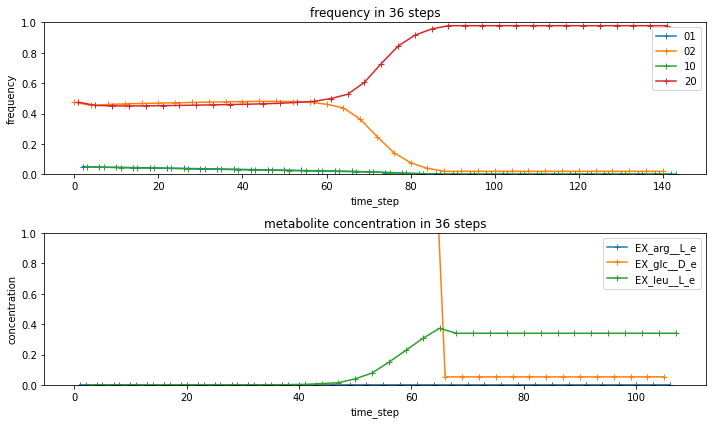

In [17]:
#simple plot
import matplotlib.pyplot as plt

# Group data by category
freq_grouped = frequency_df.groupby('pheno')
conc_grouped = concentration_df.groupby('reactions')

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# Plot for Dataset 1
# Plot each group as a separate line with different colors
for category, group in freq_grouped:
    axes[0].plot(group.index, group['frequency'], marker='+', label=category)
axes[0].set_xlabel('time_step')
axes[0].set_ylabel('frequency')
axes[0].set_title(f'frequency in {iteration} steps')
axes[0].set_ylim(0., 1.) 
axes[0].legend()

# Plot for Dataset 2
for category, group in conc_grouped:
    axes[1].plot(group.index, group['concentration'], marker='+', label=category)
axes[1].set_xlabel('time_step')
axes[1].set_ylabel('concentration')
axes[1].set_title(f'metabolite concentration in {iteration} steps')
axes[1].set_ylim(0., 1.) 
axes[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [535]:
print(tmp_experiment.loc[23]["frequency"])

[0.13355160953230288, 0.6117142689323607, 0.12965670982299418, 0.1250774117123422]


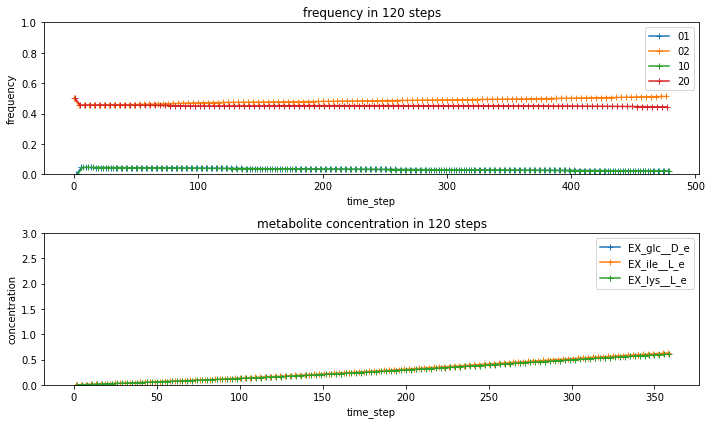

In [48]:
#simple plot
import matplotlib.pyplot as plt

# Group data by category
freq_grouped = frequency_df.groupby('pheno')
conc_grouped = concentration_df.groupby('reactions')

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# Plot for Dataset 1
# Plot each group as a separate line with different colors
for category, group in freq_grouped:
    axes[0].plot(group.index, group['frequency'], marker='+', label=category)
axes[0].set_xlabel('time_step')
axes[0].set_ylabel('frequency')
axes[0].set_title(f'frequency in {iteration} steps')
axes[0].set_ylim(0., 1.) 
axes[0].legend()

# Plot for Dataset 2
for category, group in conc_grouped:
    axes[1].plot(group.index, group['concentration'], marker='+', label=category)
axes[1].set_xlabel('time_step')
axes[1].set_ylabel('concentration')
axes[1].set_title(f'metabolite concentration in {iteration} steps')
axes[1].set_ylim(0., 3.) 
axes[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

## Everythin archived below

In [8]:
#Loop through 60 min and store frequency, abundance, metabolite concentration, and time data
from tqdm import tqdm
#intialize constant starting values
phenotypes =  ["01","10"]
freq_ls = [0.5,0.5]
abundance_ls = [0.5,0.5]
N = 10000 #integer for multinomial sampling
rxn_ls = get_reaction_list(amino_df)
iteration = 10
amino_list = amino_df["Amino acid"].to_list()
#Pre testing
leakiness_data = [0.1, 0.7]
leakiness_df = pd.DataFrame(leakiness_data, columns=["leakiness"], index=amino_list)

generation_df = pd.DataFrame(zip(freq_ls,abundance_ls),index = phenotypes, columns = ["frequency", "abundance"])
init_concentration = [30.0, 0.,0., 0.]
init_nutrient_flux = np.repeat(0.,4)
nutrient_df = pd.DataFrame(init_concentration, index = rxn_ls, columns = ["concentration"])

payoff_df, metabolite_ls = get_pairwise_payoff(generation_df, nutrient_df, amino_df,leakiness_df,strains,phenotypes)

In [15]:
payoff_df

,01,10
01,0.000000,0.260379
10,0.508775,0.000000


In [44]:
#Variation2: add leu to support 20
from tqdm import tqdm
#intialize constant starting values
phenotypes =  ["01","02","10","20"]
freq_ls = [0.05,0.45,0.05,0.45]
abundance_ls = [0.05,0.45,0.05,0.45]
N = 10000 #integer for multinomial sampling
rxn_ls = get_reaction_list(amino_df)
iteration = 60
amino_list = amino_df["Amino acid"].to_list()

#create dataframe to vary leakiness level of selected amino acid pair
leakiness_range = np.arange(0.1, 1, 0.2, dtype=float)
leakiness_range = np.round(leakiness_range, decimals=2)
leakiness_data = {"arg_leakiness": leakiness_range, "leu_leakiness": leakiness_range}
leakiness_data
leakiness_df = pd.DataFrame(leakiness_data)
def perform_invasion2(iteration, amino_df,leakiness_df,strains,freq_ls, abundance_ls, rxn_ls,phenotypes):
    #initiation
    generation_df = pd.DataFrame(zip(freq_ls,abundance_ls),index = phenotypes, columns = ["frequency", "abundance"])
    init_concentration = [30.0, 0.,0., 2.]
    init_nutrient_flux = np.repeat(0.,4)
    nutrient_df = pd.DataFrame(init_concentration, index = rxn_ls, columns = ["concentration"])

    #create storage dataframe
    experiment = pd.DataFrame(columns = ["frequency","abundance","concentration"])
    
    #store initial values
    experiment.loc[0,"frequency"] = generation_df["frequency"].tolist()
    experiment.loc[0,"abundance"] = generation_df["abundance"].tolist()
    experiment.loc[0,"concentration"] = nutrient_df["concentration"].tolist()

    for step in tqdm(range(1,iteration,1)):
        # print(step)
        generation_df, nutrient_df = update_generation(generation_df,nutrient_df,amino_df,leakiness_df,strains)
        experiment.loc[step,"frequency"] = generation_df["frequency"].tolist()
        experiment.loc[step,"abundance"] = generation_df["abundance"].tolist()
        experiment.loc[step,"concentration"] = nutrient_df["concentration"].tolist()
        
    return experiment

In [45]:
leakiness_data = [0.1, 0.1]
tmp_leakiness = pd.DataFrame(leakiness_data, columns=["leakiness"], index=amino_list)

tmp_experiment = perform_invasion(iteration, amino_df,tmp_leakiness,strains,freq_ls, abundance_ls, rxn_ls,phenotypes)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [01:03<00:00,  1.08s/it]
